# Аналитика в Яндекс.Афише

## Описание проекта

Требуется помочь маркетологам оптимизировать маркетинговые затраты проанализировав доступны данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:

*  лог сервера с данными о посещениях сайта Яндекс.Афиши;
*  выгрузка всех заказов за этот период;
*  статистика рекламных расходов.

Нужно  понять:

*  как люди пользуются продуктом;
*  когда они начинают покупать;
*  сколько денег приносит каждый клиен;
*  когда клиент окупается.

# Подготовка данных

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
from dotenv import load_dotenv

In [2]:
pd.options.display.float_format = '{:0.3f}'.format
pd.options.mode.chained_assignment = None
pd.set_option('display.expand_frame_repr', False)

sns.set_theme(context='paper',
              palette='muted',
              style='whitegrid',
              font_scale=1.1,)

plt.rcParams.update({'lines.linewidth': 1.25,
                     'grid.linewidth': 0.5,
                     'grid.alpha': 0.5,
                     'figure.constrained_layout.use': True,
                     'figure.figsize': (10, 6)})

%config InlineBackend.figure_format = 'retina'

Загрузим и посмотрим данные.

In [3]:
load_dotenv(dotenv_path='./credentials.env')
url = os.getenv('URL')

visits = pd.read_csv(url + 'visits_log.csv', parse_dates=[1,3])
orders = pd.read_csv(url + 'orders_log.csv', parse_dates=[0])
costs = pd.read_csv(url + 'costs.csv', parse_dates=[1])

Приведем названия признаков к pythonic way.

In [4]:
for df in [visits, orders, costs]:
    df.columns = df.columns.str.lower().str.replace(' ', '_')

Оценим есть ли пропуски или дубликаты в данных.

In [5]:
def df_analysis(df):
    print(f''.center(60, '-'))
    df.info()
    print(''.center(60, '-'),
    f'Количество явных дубликатов:\t{df.duplicated().sum()}',
    f'Количество пропусков в данных:\t{df.isna().sum().sum()}',
    ''.center(60, '-'), sep='\n', end='\n\n')
    
for df in [visits, orders, costs]: df_analysis(df)

------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
------------------------------------------------------------
Количество явных дубликатов:	0
Количество пропусков в данных:	0
------------------------------------------------------------

------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------

## Выводы:

* Данные загружены.
* Явных дубликатов и пропусков нет.

# Отчёт и расчет метрик

## Продукт

### Оценка активности пользователей: MAU, WAU и DAU

После 2018 года наметился спад, особенно в сегменте персональных компьютеров. Это может быть вызвано в том числе сезонностью, так как предыдущий подъем был осенью.

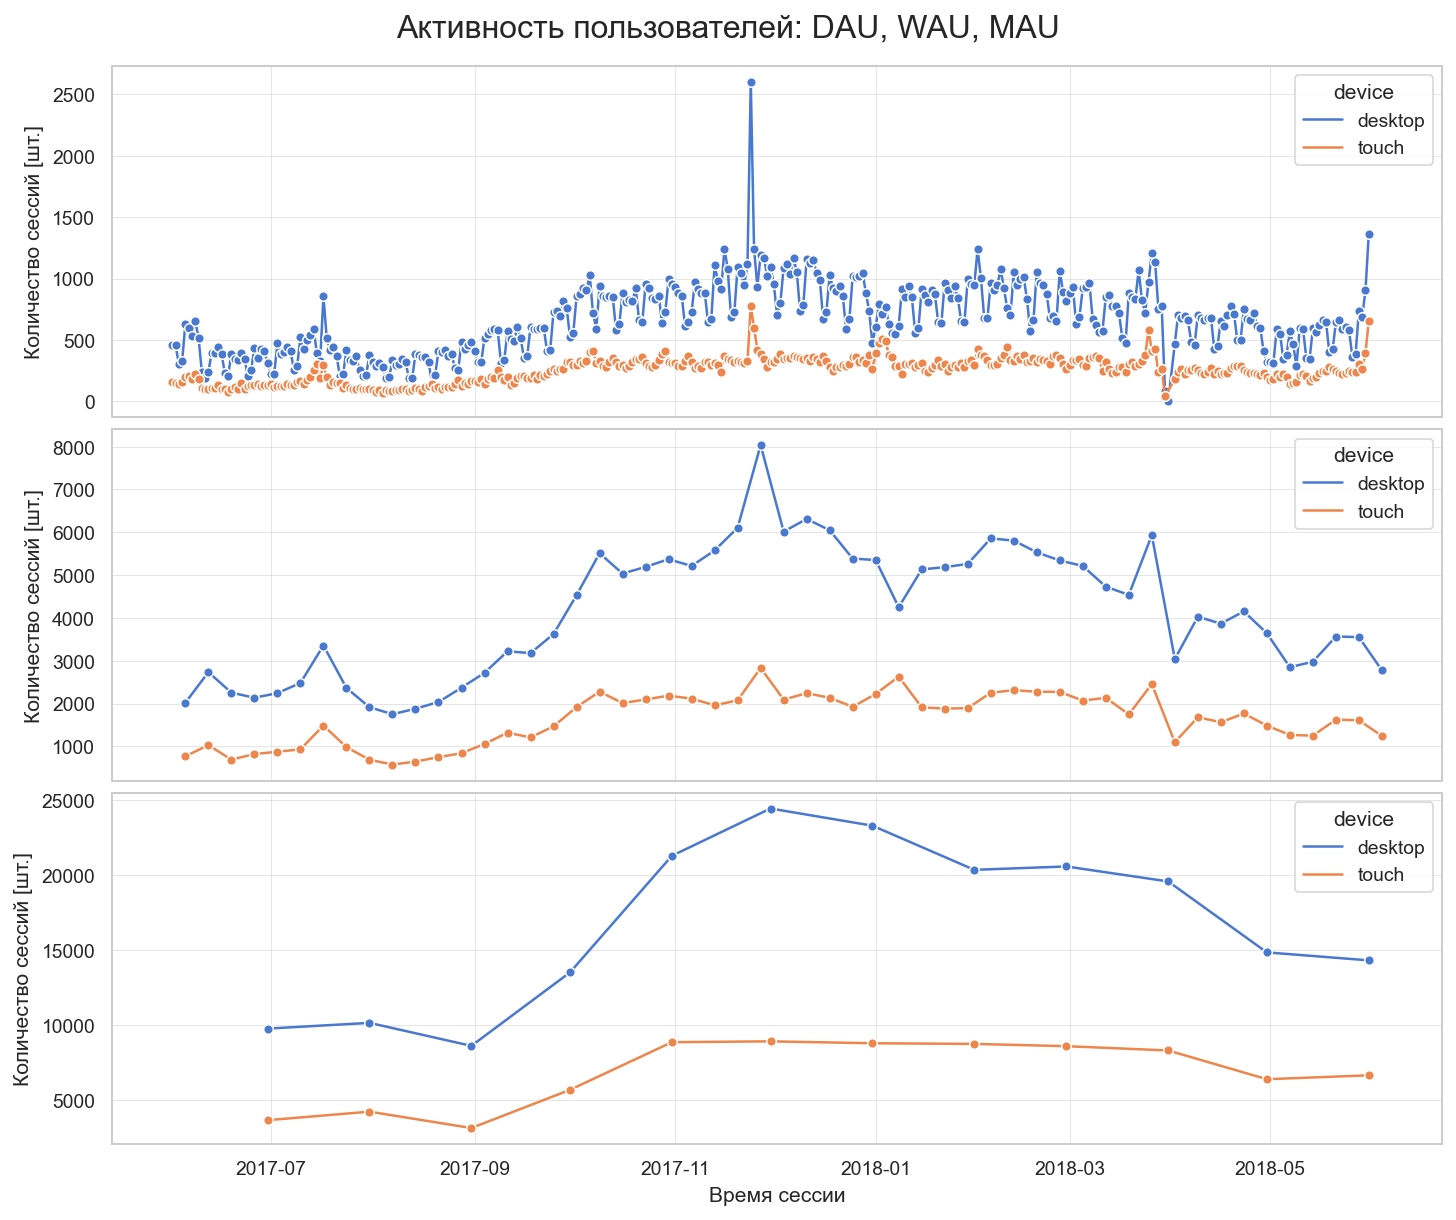

In [6]:
dqm_au = {}

fig, axes = plt.subplots(3, 1, figsize=(10,8), sharex=True)
for i, (freq, xau) in enumerate([('D', 'DAU'), ('W-MON', 'WAU'), ('M', 'MAU')]):
    data = visits.groupby(['device',pd.Grouper(key='start_ts', freq=freq)])['uid'].nunique().reset_index()
    dqm_au['Avg ' + xau] = [round(
        visits.groupby(pd.Grouper(key='start_ts', freq=freq))['uid'].nunique().mean()
    )]
    sns.lineplot(data=data, x='start_ts', y='uid', hue='device',
                 marker='o', ax=axes[i],
                 # label=[f'Метрика {xau}', f'Метрика {xau}']
                )
for ax in axes:
    ax.set_ylabel('Количество сессий [шт.]')
    ax.set_xlabel('Время сессии')
    
plt.suptitle('Активность пользователей: DAU, WAU, MAU', fontsize=16, y=1.04)
plt.show()

In [7]:
pd.DataFrame(dqm_au, index=['Metric Value'])

,Avg DAU,Avg WAU,Avg MAU
Metric Value,906,5722,23228


### Длительность одной сессия

Количество сессий в день.

In [8]:
print(f"Сессий в день: {round(visits.groupby(pd.Grouper(key='start_ts', freq='1D'))['uid'].count().mean())}")

Сессий в день: 985


In [9]:
visits['session_duration'] = (visits['end_ts']-visits['start_ts']).dt.seconds
visits['session_duration'].agg(['mean', 'median'])

mean     643.506
median   300.000
Name: session_duration, dtype: float64

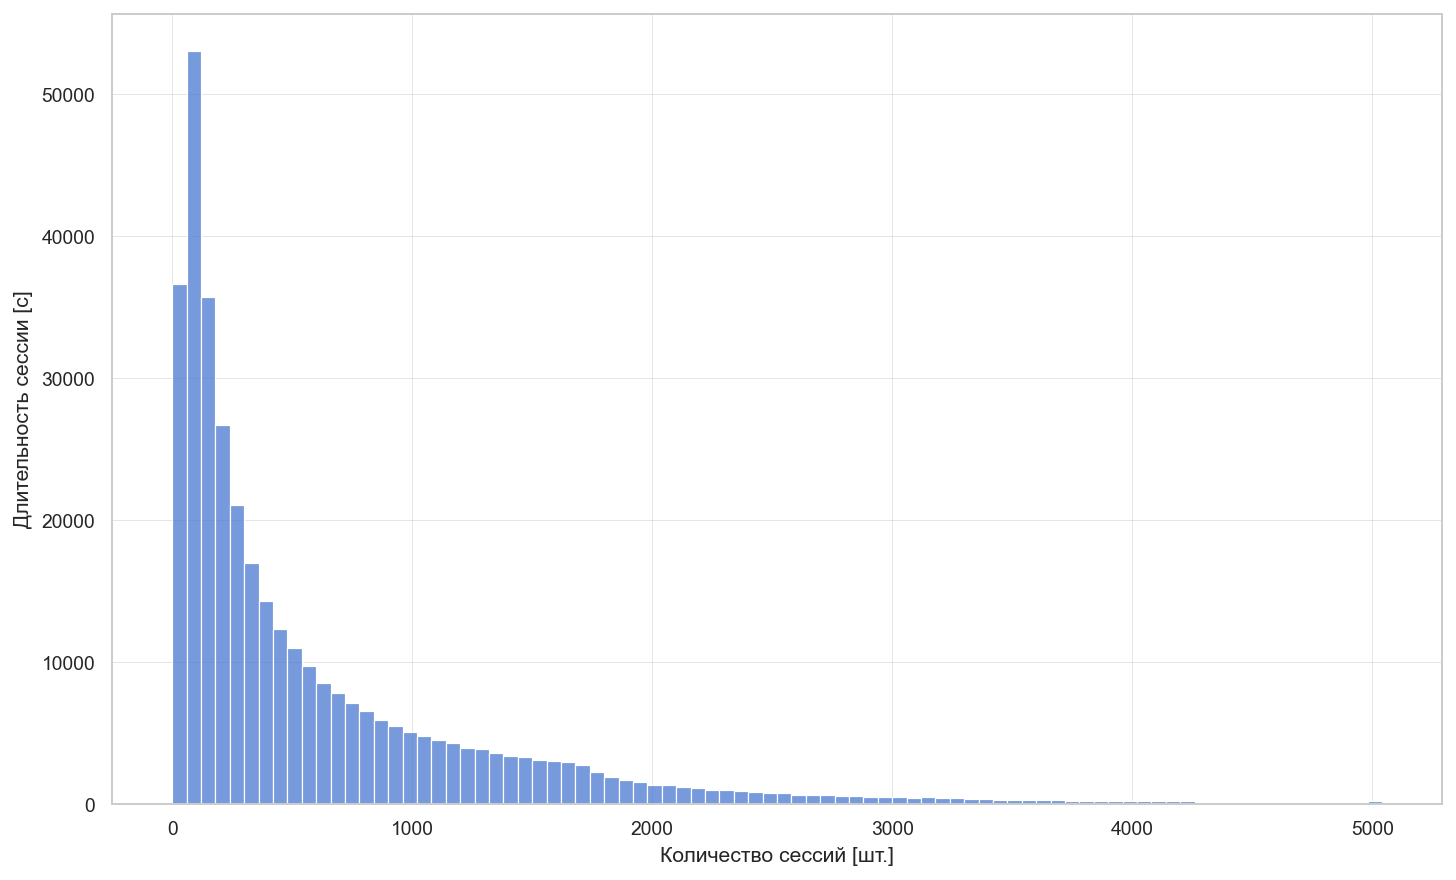

In [10]:
ax = sns.histplot(data=visits['session_duration'], binwidth=60, binrange=[0,5000])
ax.set_ylabel('Длительность сессии [c]')
ax.set_xlabel('Количество сессий [шт.]');

Есть достаточно длительные сессии продолжительностью более 2000, 3000 и даже 5000 секунд.

session_duration имеет биномиальное распределение.

### Retention Rate (Как часто люди возвращаются?)

Найдем время когда пользователь впервые посетил ресурс и сколько времени прошло с момента первого посещения.

In [11]:
visits['first_visit'] = visits.groupby(['uid'])['start_ts'].transform('min')
visits['start_month'] = visits['first_visit'].astype('datetime64[M]')

Определим "возраст" когорты.

In [12]:
visits['cohort_idx'] = round(
    1 + (visits['start_ts'].astype('datetime64[M]') - visits['first_visit'].astype('datetime64[M]'))
    / np.timedelta64(1,'M'))

Теперь можно сгруппировать данные по start_month, cohort_idx и создать сводную таблицу с коэффициентом удержания.

In [13]:
agg_visits = visits.groupby(['start_month','cohort_idx']).agg({'uid':'nunique'}).reset_index()
retention = agg_visits.pivot_table(index='start_month',
                                   columns='cohort_idx',
                                   values='uid')

# Чтобы получить относительные величины разделим сводную таблицу на первый столбец.
retention = retention.divide(retention.iloc[:,0], axis=0)

In [14]:
# Функция для построения heatmap'ов.
def plot_heatmap(df, fmt, cmap, title):
    ax = sns.heatmap(df, annot=True, fmt=fmt, #vmax=0.1,
                     linewidths=.3, cmap=cmap,
                     yticklabels=df.index.strftime('%Y-%m'))

    plt.suptitle(title, fontsize=16, y=1.04)
    ax.set_ylabel('Когорта')
    ax.set_xlabel('Месяц жизни когорты')
    plt.show()

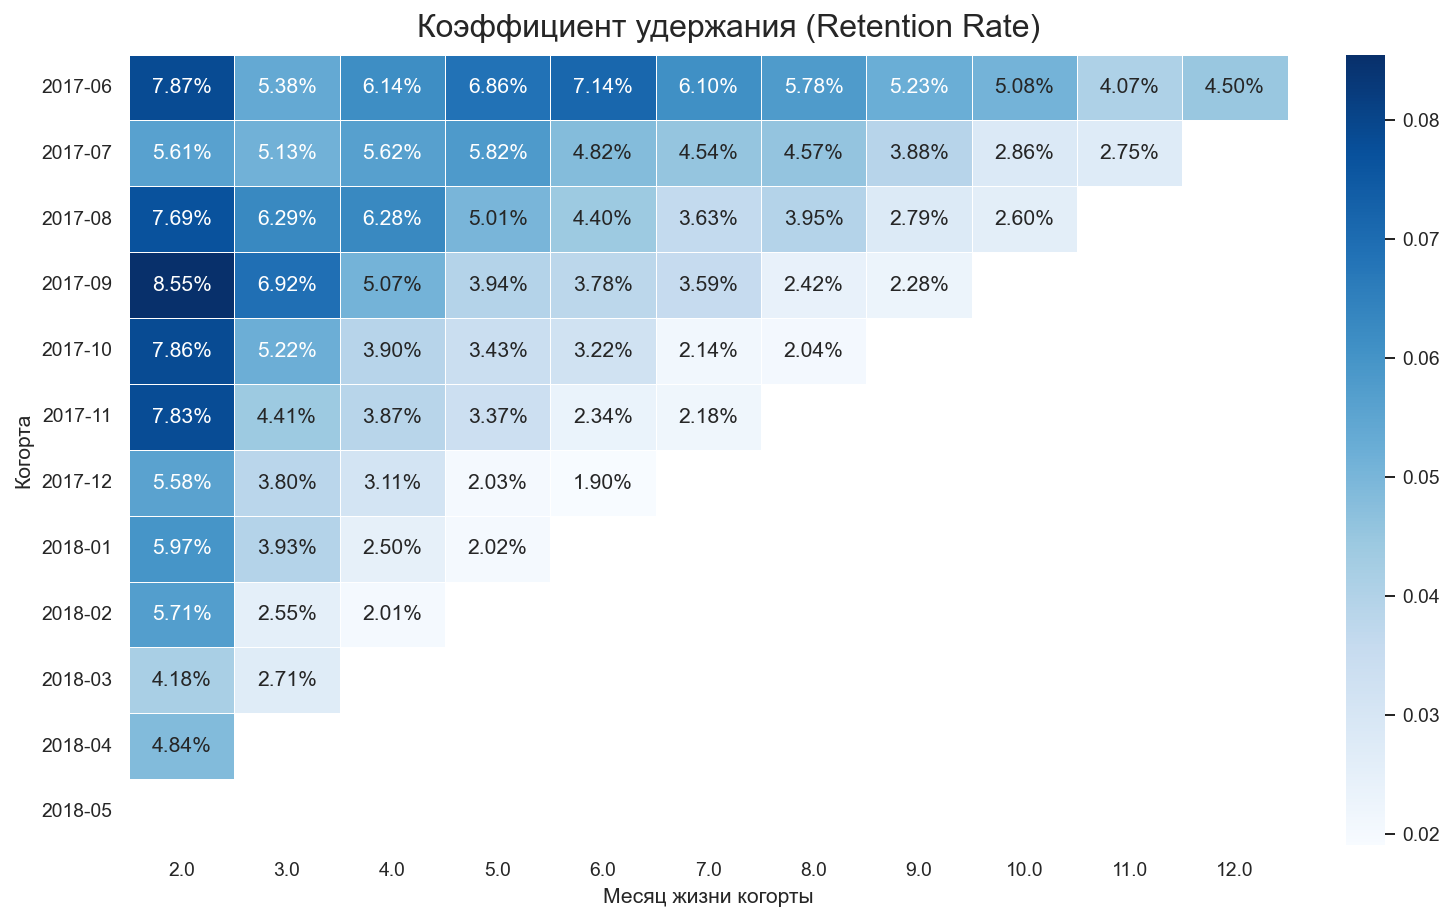

In [15]:
# Строим RR начиная со второго месяца, так как в 1 у всех когорт 100%.
plot_heatmap(retention.iloc[:,1:], '.2%', 'Blues',
             title='Коэффициент удержания (Retention Rate)')

Видно что коэффициент удержания достаточно низкий, что связано с особенностью сервиса.

Со времене RR снижается, так у апрельской когорты он составляет всего 4.8%.

## Продажи

### Количество дней предшествующих покупке

Добавим в visits время первой покупки. Объединять будем по how='left', так как после посещения не обязательно следует покупка.

In [16]:
visits = visits.merge(orders.groupby(['uid'])['buy_ts'].agg('min'),
                      on='uid', how='left')

Только 72% поситителей совершают покупку.

In [17]:
print(f"{visits.buy_ts.isna().mean():.2%}")

72.90%


Получим количеству дней с момента от первого посещения до первой покупки, совершенной пользователем.

In [18]:
visits['days_before_order'] = (visits.buy_ts - visits.first_visit).dt.days

Построим гистограмму. Учитываем только пользователей совершивших покупку после 1 дня.

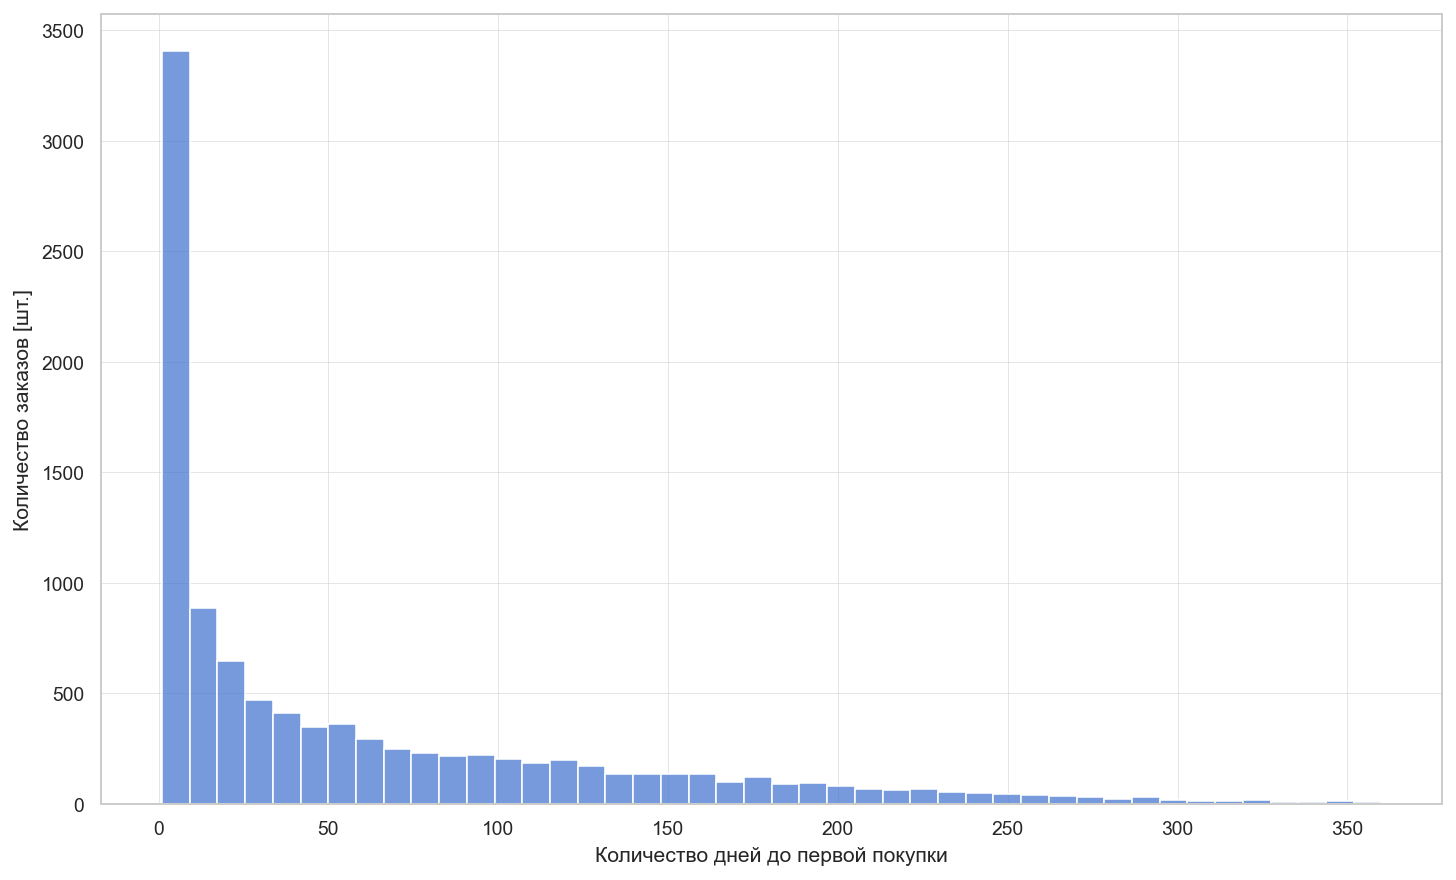

In [19]:
ax = sns.histplot(data=visits[['first_visit', 'days_before_order']].drop_duplicates()['days_before_order'],
                  binrange=[1,360])
ax.set_ylabel('Количество заказов [шт.]')
ax.set_xlabel('Количество дней до первой покупки');

Большинство покупок совершаются в первый день, их в 8 раз больше чем на следующий день.

In [20]:
visits[['first_visit', 'days_before_order']].drop_duplicates()['days_before_order'].value_counts()[0]

25160

### Количество покупок за период?

Время первой покупки.

In [21]:
orders['first_order'] = orders.groupby(['uid'])['buy_ts'].transform('min')

Посчитаем число заказов в неделю, в том числе и только для новых пользователей.

In [22]:
week_orders = pd.DataFrame()
# Количество покупок за период. Будем считать несколько покупок одним и тем же клиентом за период за одну операцию.
week_orders['purchase_cnt'] = orders.resample('W-MON', on='buy_ts').agg({'uid':'nunique'})
# Количество покупок совершенных новыми покупателями.
week_orders['purchase_cnt_new'] = orders.query('first_order == buy_ts').resample('W-MON', on='buy_ts').agg({'revenue': 'count'})

week_orders.reset_index(inplace=True)

Из графика следует что число повторных заказов стабилизировалось и не превышает 15%.

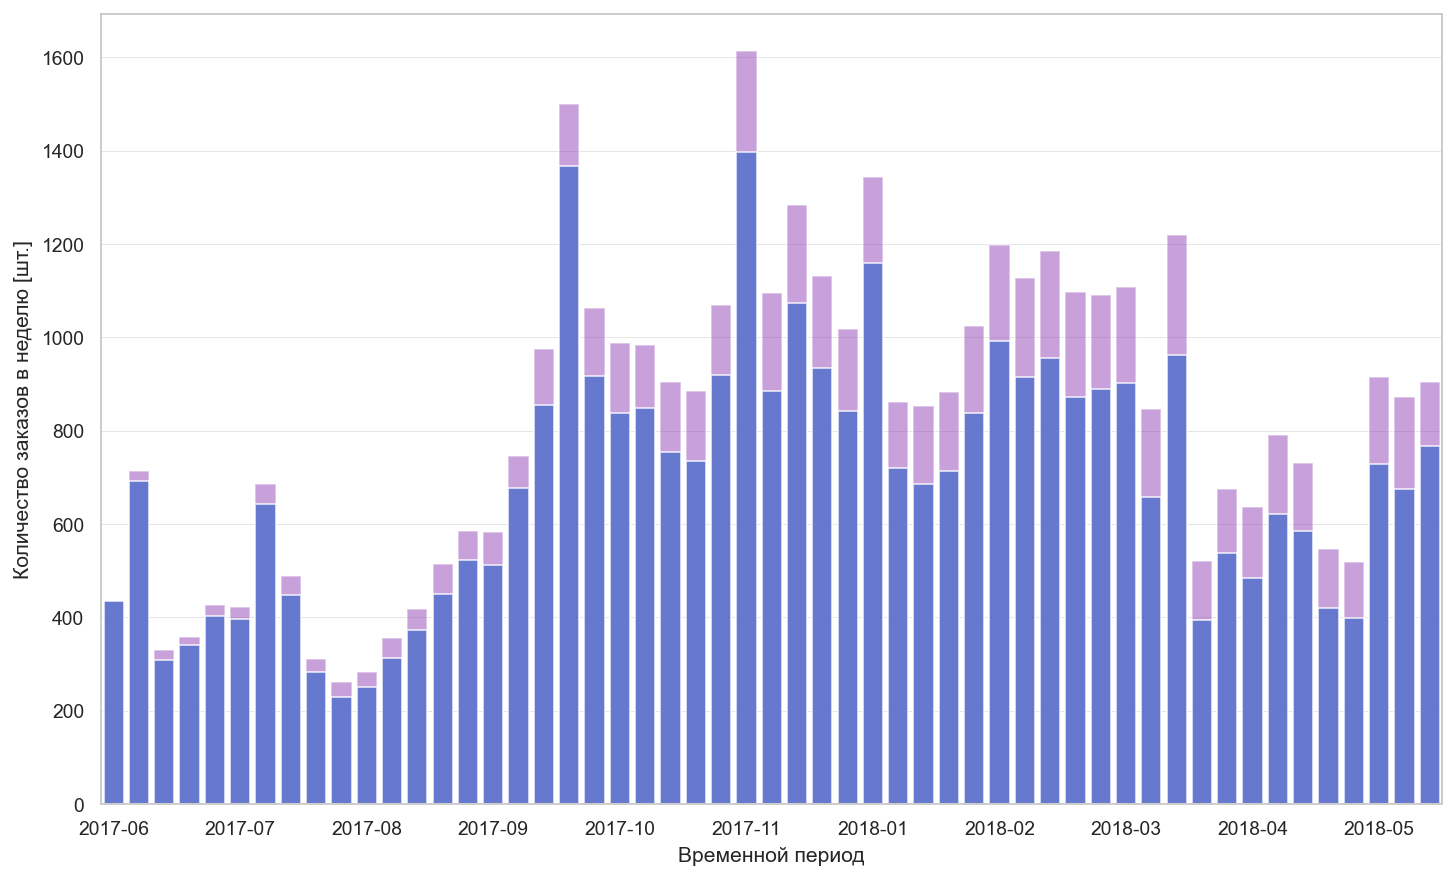

In [23]:
ax = sns.barplot(x='buy_ts', y='purchase_cnt',
                 color='darkorchid', alpha=0.5,
                 data=week_orders, estimator='sum')
sns.barplot(x='buy_ts', y='purchase_cnt_new',
            color='royalblue', alpha=0.85,
            data=week_orders, estimator='sum')

x_dates = week_orders['buy_ts'].dt.strftime('%Y-%m')
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % 5 != 0:
        label.set_visible(False)
ax.set_xticklabels(labels=x_dates)
ax.set_ylabel('Количество заказов в неделю [шт.]')
ax.set_xlabel('Временной период');
plt.show()

### Средний чек

In [24]:
print(f"{orders['revenue'].mean():.2f}")

5.00


### Lifetime Value (LTV)

In [25]:
# Получим месяц покупки и первый месяц заказа.
orders['first_order_month'] = orders.first_order.astype('datetime64[M]')
orders['order_month'] = orders.buy_ts.astype('datetime64[M]')

Посчитаем количество новых покупателей по месяцам.

In [26]:
orders['new_buyers'] = orders.groupby('first_order_month')['uid'].transform('nunique')

Найдем возраст когорты.

In [27]:
orders['cohort_idx'] = round(
    1 + (orders['order_month']- orders['first_order_month']) / np.timedelta64(1,'M'))

Объединим результаты и посчитаем LTV.

In [28]:
agg_orders = orders.groupby(['cohort_idx','first_order_month']).agg(
    {'revenue': 'sum',
     'new_buyers': 'min'}).reset_index()

# Разделим валовую прибыль когорт за каждый месяц на число пользователей в когорт.
agg_orders['ltv'] = agg_orders.revenue / agg_orders.new_buyers

agg_orders.head()

,cohort_idx,first_order_month,revenue,new_buyers,ltv
0,1.000,2017-06-01,9557.490,2023,4.724
1,1.000,2017-07-01,11557.650,1923,6.010
2,1.000,2017-08-01,7228.830,1370,5.277
3,1.000,2017-09-01,14568.530,2581,5.645
4,1.000,2017-10-01,21716.200,4340,5.004


Теперь можно сгруппировать данные и создать сводную таблицу.

> Лучшую LVT показывают июньская и сентябрьская группы.

> Данные за 2018-06-01 похожи на выброс и могут не учитыватся.

In [29]:
ltv = agg_orders.pivot_table(index='first_order_month', columns='cohort_idx',
                             values='ltv', aggfunc='mean').cumsum(axis=1)

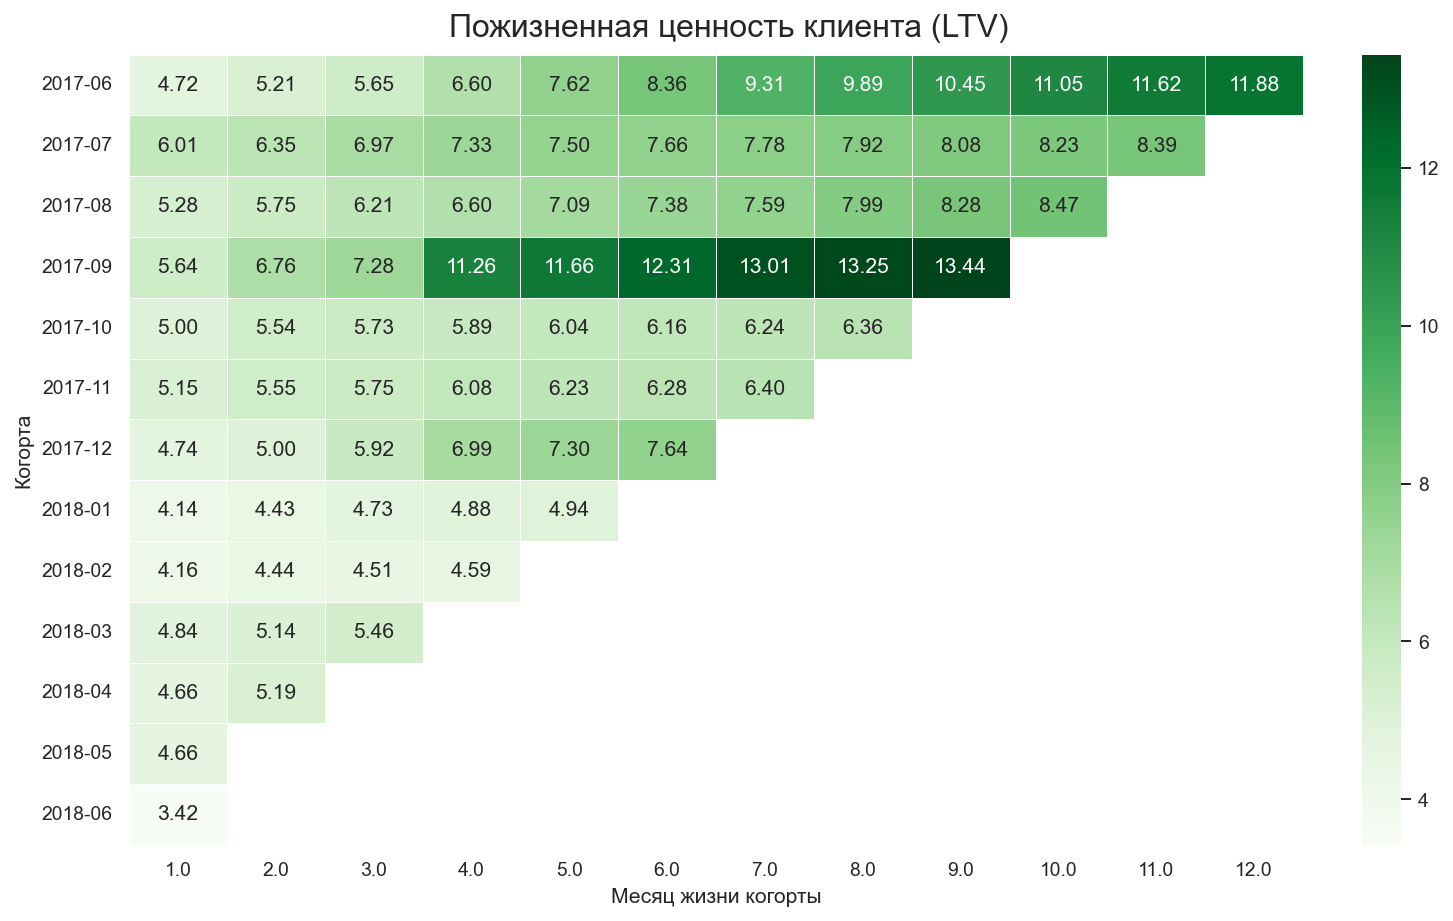

In [30]:
plot_heatmap(ltv, '.2f', 'Greens',
             title='Пожизненная ценность клиента (LTV)')

## Маркетинг

### Расходы на рекламу

Суммарные расходы: 329131.62



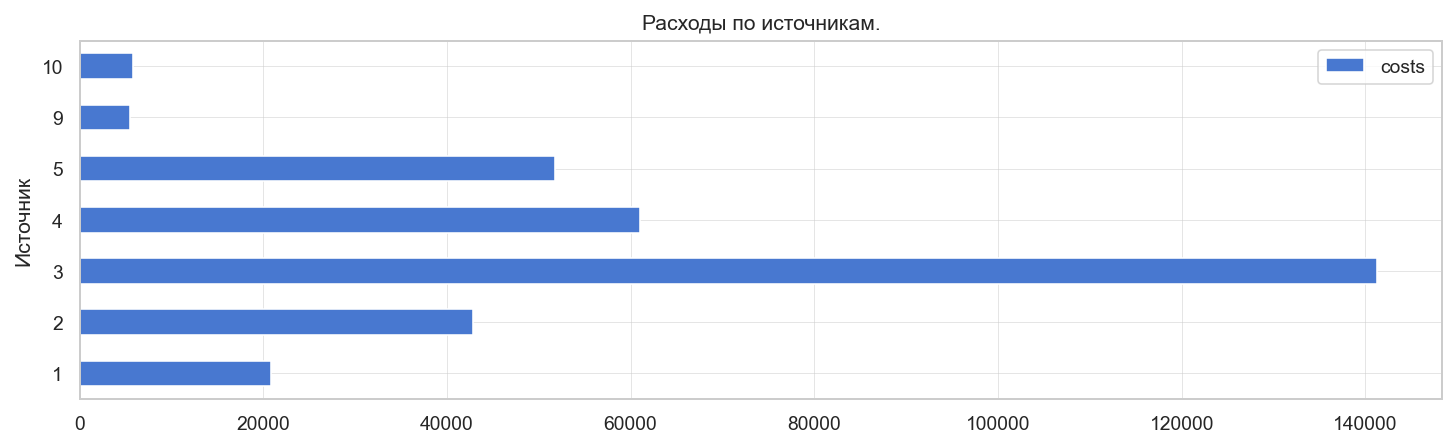

In [31]:
costs.groupby('source_id').agg({'costs':'sum'}).plot.barh(rot=0, figsize=(10,3),
    title='Расходы по источникам.', xlabel='Источник', ylabel='Затраты');

print(f"Суммарные расходы: {costs['costs'].sum()}", end='\n\n')

> Самым затратным является источник рекламы 3.

Расходы по месяцам.

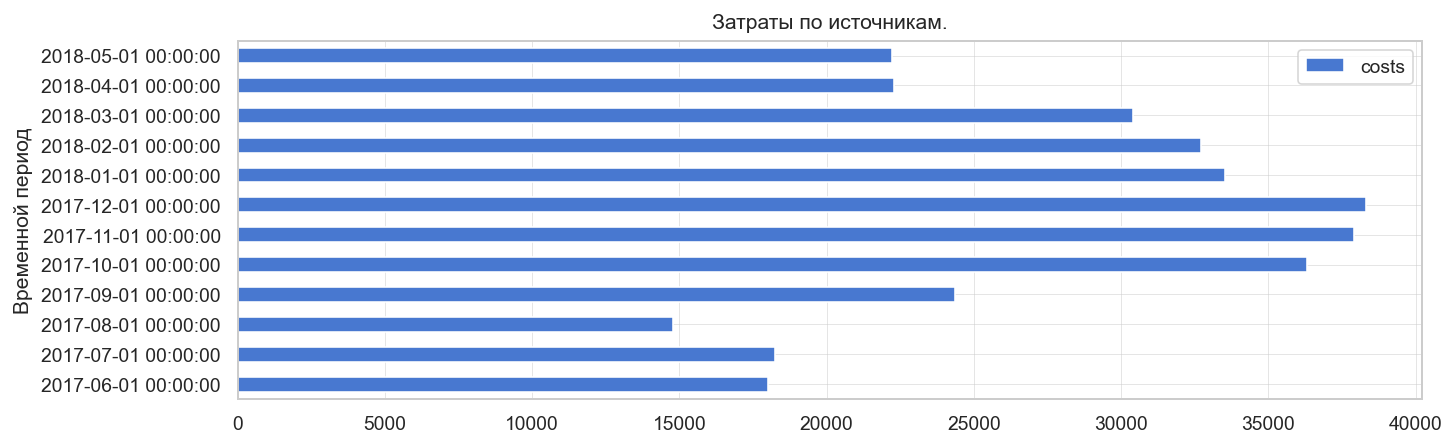

In [32]:
costs_per_month = costs.groupby(costs['dt'].astype('datetime64[M]')).agg({'costs':'sum'}).reset_index()
costs_per_month.plot(kind='barh', rot=0, figsize=(10,3), x='dt', y='costs',
                     title='Затраты по источникам.', xlabel='Временной период', ylabel='Затраты');

In [33]:
print(f'Среднемесячные траты: {costs_per_month.costs.mean():.2f}')

Среднемесячные траты: 27427.63


### Стоимость привлечения одного покупателя в зависимости от источника

Customer acquisition cost (CAC) рассчитывается как отношение затрат на привлечение к количеству покупателей.

Количество покупателей привлеченных из источника.

In [34]:
customers_source = pd.merge(
    visits[['uid','source_id']],
    orders[['uid']], on='uid'
).groupby(['source_id']).agg({'uid':'nunique'}).reset_index()

customers_source.rename(columns={'uid':'customers'}, inplace=True)

Добавим customers_source в costs и посчитаем стоимость привлечения.

> Эффективнее всего привлекать клиентов с источников 9, 1 и 4. В то время как источник 3 самый дорогой - CAC равен 10.2.

In [35]:
costs = costs.merge(customers_source, on='source_id')
cac = costs.groupby(['source_id', 'customers']).agg({'costs':'sum'}).reset_index()
cac['cac'] = cac.costs / cac.customers
cac

,source_id,customers,costs,cac
0,1,7138,20833.270,2.919
1,2,7305,42806.040,5.860
2,3,13846,141321.630,10.207
3,4,14253,61073.600,4.285
4,5,10156,51757.100,5.096
5,9,2793,5517.490,1.975
6,10,1773,5822.490,3.284


### Окупаемость маркетинговых компаний (ROMI)

Рассчитаем ROMI (Return on Marketing Investment) по когортам, для этого поделим LTV на CAC.

In [36]:
romi = pd.merge(agg_orders, costs_per_month,
                left_on='first_order_month', right_on='dt')
romi['cac'] = romi['costs'] / romi['new_buyers']
romi['romi'] = romi['ltv'] / romi['cac']

romi = romi.pivot_table(
    index='first_order_month', 
    columns='cohort_idx', 
    values='romi', 
    aggfunc='mean'
).cumsum(axis=1)

Построим heatmap по ROMI.

> Реклама окупилась только для двух когорт.

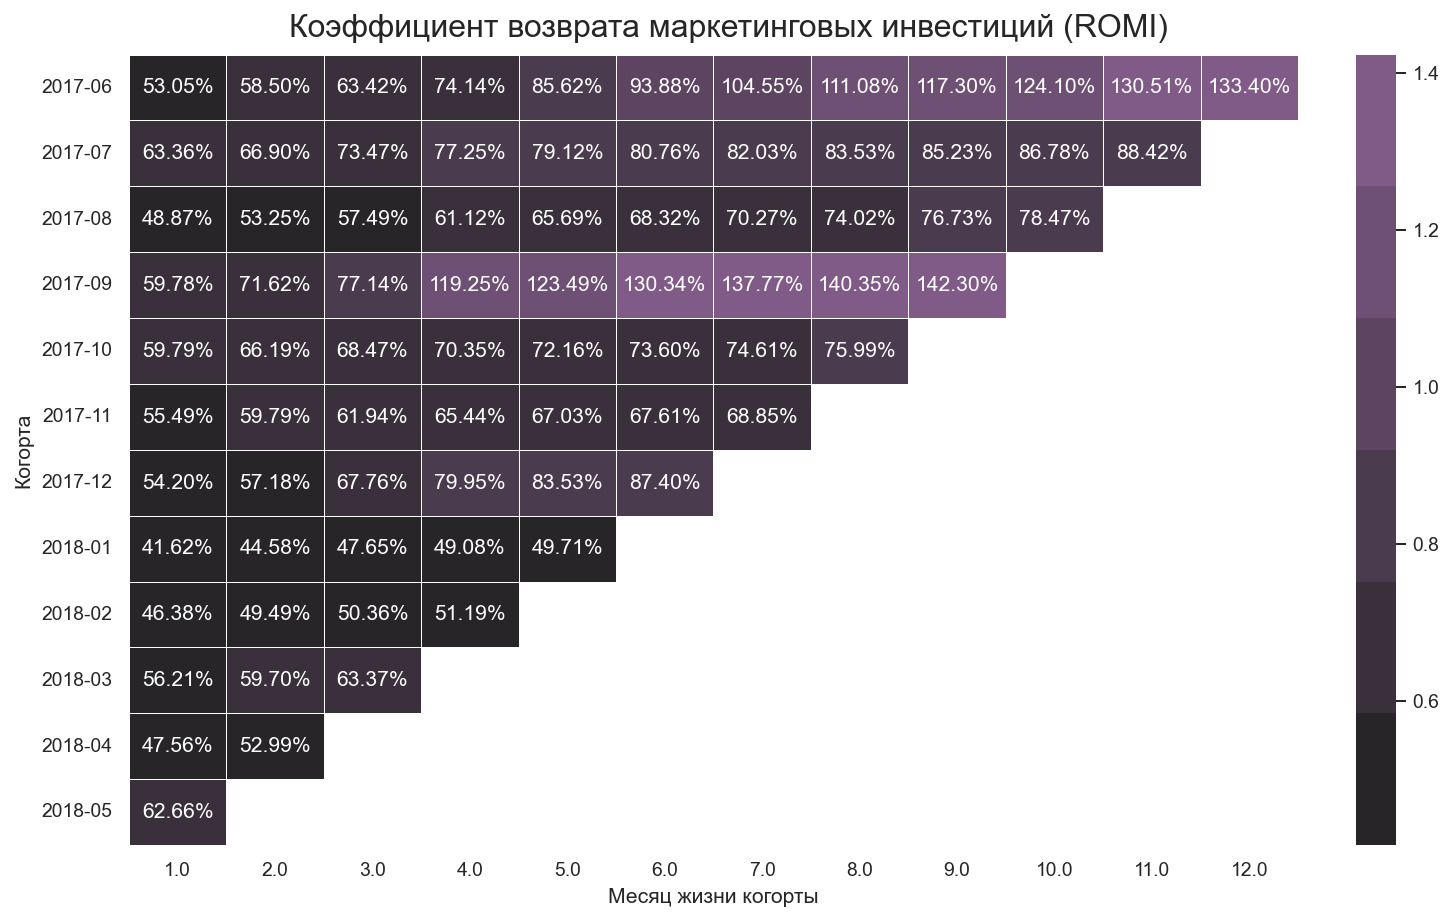

In [37]:
plot_heatmap(romi, '.2%', sns.dark_palette("muted purple", input="xkcd"),
             title='Коэффициент возврата маркетинговых инвестиций (ROMI)')

### Рассчитаем ROMI по источникам рекламы

Выполним агрегацию выручки по источникам.

In [38]:
# Используем first(), так ка нам нужно первое упоминание.
agg_orders = orders.merge(
    visits.sort_values('start_ts').groupby(['uid'])['source_id'].first().reset_index(),
    on='uid', how='left')
agg_orders = agg_orders.groupby(['source_id'])['revenue'].sum().reset_index()
agg_orders

,source_id,revenue
0,1,31090.550
1,2,46923.610
2,3,54511.240
3,4,56696.830
4,5,52624.020
5,7,1.220
6,9,5759.400
7,10,4450.330


ROMI в нашем случае — это отношение выручки к затратам на рекламу в разрезе источников рекламы.

In [39]:
romi = agg_orders.set_index('source_id').revenue \
    .divide(cac.set_index('source_id').costs, axis=0).reset_index()
romi.columns = ['source_id', 'romi']

Самым лучшим является 1 источник рекламы. 2, 5 и 6 источники расположены вблизи порога окупаемости. Остальные источники убыточны.

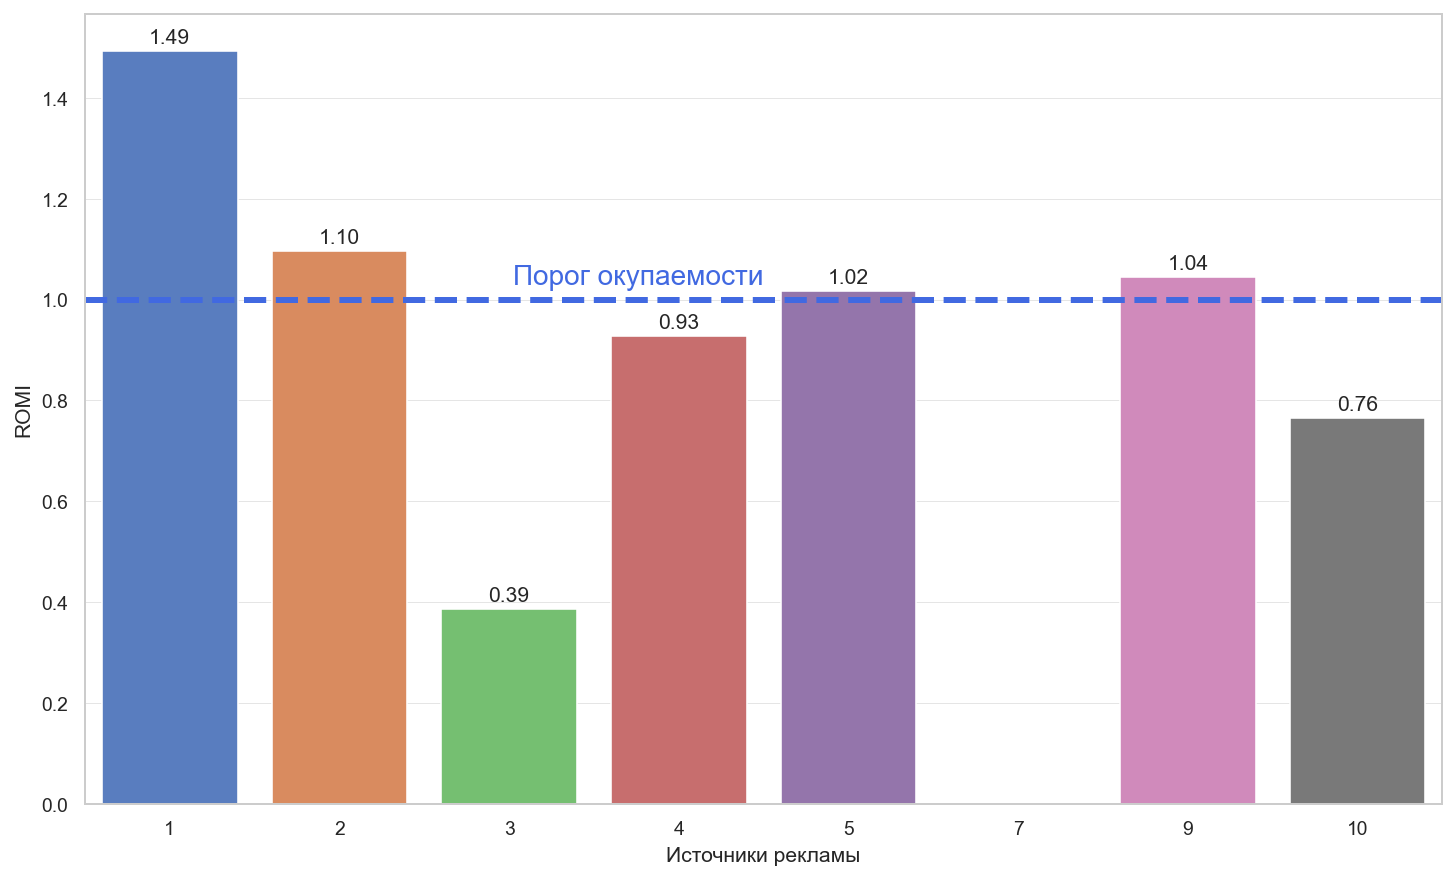

In [40]:
ax = sns.barplot(y='romi', x='source_id', data=romi)

plt.axhline(y=1, color='royalblue', linestyle='--', linewidth=3)
ax.text(.5, 0.65, 'Порог окупаемости',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='royalblue', fontsize=14)

ax.bar_label(ax.containers[0], fmt='%.2f', padding=2)
ax.set_ylabel('ROMI')
ax.set_xlabel('Источники рекламы');

# Вывод

* Наиболее успешна была маркетинговая компания в сентябре 2017.
* Самым удачным источником привлечения клиентов является первый источник, остальные слабоэффективны или убыточны.